Veena Ghorakavi

In [1]:
!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
from google.colab import files
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
uploaded = files.upload()

     |████████████████████████████████| 317kB 10.7MB/s 
     |████████████████████████████████| 245kB 25.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81696 sha256=582d9dbe20256e531b26c251a38e2a6c01335aa260c0f4322fa8ec7497e41409
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Saving Tweets.csv to Tweets.csv


In [2]:
Data = pd.read_csv("Tweets.csv")

Data Column Understanding

In [3]:
Data = Data.loc[:, Data.columns.intersection(['text','airline_sentiment'])]

In [4]:
Data.shape

(14640, 2)

In [5]:
Data.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Data Pre-Processing:
Strip HTML
Remove Special Characters
Remove numbers
Replace contractions
Tokenize
Lowercase all words
Remove punctuation
Lemmatize and normalize
Print first five rows

In [6]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

Data['text'] = Data['text'].apply(lambda x: strip_html(x))

In [7]:
import re
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

Data['text'] = Data['text'].apply(lambda x: remove_special_characters(x))

In [8]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

Data['text'] = Data['text'].apply(lambda x: remove_numbers(x))

In [9]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

Data['text'] = Data['text'].apply(lambda x: replace_contractions(x))

In [10]:
Data['text'] = Data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [11]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
Data['text'] = Data['text'].apply(lambda x: to_lowercase(x))

In [12]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Data['text'] = Data['text'].apply(lambda x: remove_punctuation(x))

In [13]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return ' '.join(new_words)
Data['text'] = Data.apply(lambda row: lemmatize_list(row['text']), axis=1)
Data.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you have add commercials to...
2,neutral,virginamerica i do not today must mean i need ...
3,negative,virginamerica its really aggressive to blast o...
4,negative,virginamerica and its a really big bad thing a...


Vectorization and Evaluation:
CountVectorizer
TFIDVectorizer

In [14]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(Data['text'])

data_features = data_features.toarray()                        # Convert the data features to array.

In [15]:
data_features.shape

(14640, 1000)

In [16]:
#Convert all sentiments to numbers to use for data analysis
Data['airline_sentiment'] = Data['airline_sentiment'].replace(['negative'], 0)
Data['airline_sentiment'] = Data['airline_sentiment'].replace(['neutral'],1)
Data['airline_sentiment'] = Data['airline_sentiment'].replace(['positive'], 2)
labels = Data['airline_sentiment']

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size=0.3, random_state=42)

In [18]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
nan


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: fit() missing 1 required positional argument: 'y'

  FitFailedWarning)


In [19]:
result = forest.predict(X_test)

In [20]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7176912568306011


In [21]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

[[2617  150   47]
 [ 451  371   62]
 [ 236  110  348]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


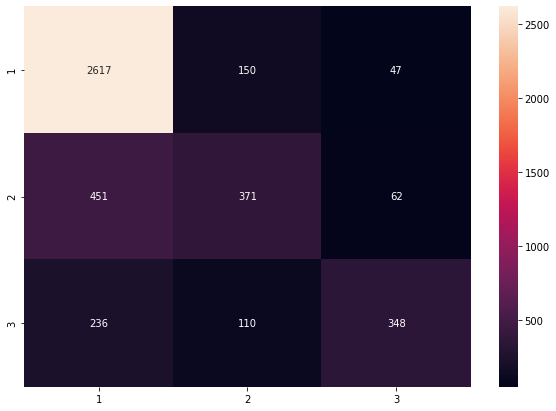

In [22]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"], columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(Data['text'])

data_features = data_features.toarray()

data_features.shape

(14640, 1000)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7146857923497267


In [25]:
result = forest.predict(X_test)

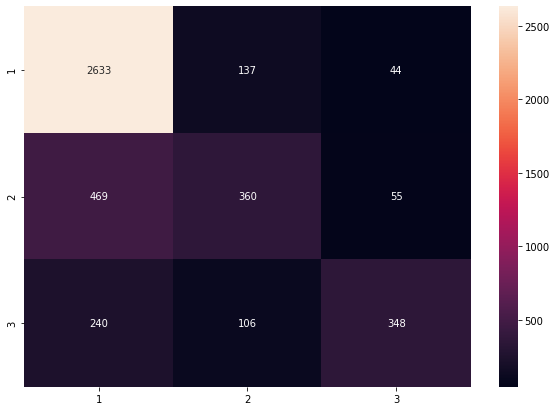

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

Summary:

- I used dataset which has reviews in text format and sentiments as positive, neutral, and negative. Negative was assigned a value of 0, neutral is assigned a value of 1, and positive is assigned a value of 2. 
- The goal was to build a model for text classification.
- The data was pre-processed using the techniques that were proscribed by the Great Learning Team.
- The pre-precessed data is lemmatized.
- The classification model was built using RandomForest with CountVectorizer and TFIDVectorizer. The results were visualized with confusion matrix.
- The overall results showed that the classifier worked fairly well. The models were well-fitted and predicted well.
- Due to space constraints, the model was limited to 50000 entries. I can use more entries for a better model. I can also use more pre-processing techniques to better understand the data. I can also compare the results with the results from stemming to see which technique works better. I only used lemmatization. 